In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Preprocessing

In [2]:
# Load interaction data
interaction_pairs = []
with open('interactions_data.txt', 'r') as file:
    for line in file:
        pdb_id1, pdb_id2, interaction = line.strip().split()
        interaction_pairs.append((pdb_id1.upper(), pdb_id2.upper(), int(interaction)))

In [3]:
# Load protein sequences
sequences_df = pd.read_csv('pdb_sequences_success.csv')

# Create a dictionary mapping from (pdb_id, chain_id) to sequence
sequence_dict = {}
for index, row in sequences_df.iterrows():
    key = (row['pdb_id'], row['chain_id'])
    sequence = row['sequence']
    sequence_dict[key] = sequence

# Update filtered_sequence_dict to map pdb_id to the smallest sequence
sequence_dict_pdb_only = {}

for key, sequence in sequence_dict.items():
    pdb_id, chain_id = key
    if pdb_id not in sequence_dict_pdb_only:
        sequence_dict_pdb_only[pdb_id] = sequence
    else:
        if len(sequence) < len(sequence_dict_pdb_only[pdb_id]):
            sequence_dict_pdb_only[pdb_id] = sequence

# Filter pairs where both sequences are available and valid
filtered_pairs = []
missing_or_invalid_sequences = []

for pdb_id1, pdb_id2, interaction in interaction_pairs:
    if pdb_id1 in sequence_dict_pdb_only and pdb_id2 in sequence_dict_pdb_only:
        filtered_pairs.append((pdb_id1, pdb_id2, interaction))
    else:
        missing_or_invalid_sequences.append((pdb_id1, pdb_id2))

In [4]:
# Standard amino acids, including 'X' for unknowns
amino_acids = 'ACDEFGHIKLMNPQRSTVWYX'

# Create amino acid to integer mapping, starting from 1 to reserve 0 for padding
aa_to_int = {aa: idx + 1 for idx, aa in enumerate(amino_acids)}
aa_to_int['<PAD>'] = 0  # Add a padding token mapped to 0

def integer_encode_sequence(sequence, max_length):
    # Map amino acids to integers
    int_sequence = [aa_to_int.get(aa, aa_to_int['X']) for aa in sequence[:max_length]]
    # Pad with zeros if sequence is shorter than max_length
    padding_length = max_length - len(int_sequence)
    if padding_length > 0:
        int_sequence += [aa_to_int['<PAD>']] * padding_length  # 0 is the padding index
    return int_sequence

sequence_lengths = [len(seq) for seq in sequence_dict_pdb_only.values()]
max_sequence_length = max(sequence_lengths)
print(f"Maximum sequence length: {max_sequence_length}")

Maximum sequence length: 4646


In [5]:
X = []
y = []

for pdb_id1, pdb_id2, interaction in tqdm(filtered_pairs, desc="Processing pairs"):
    seq1 = sequence_dict_pdb_only[pdb_id1]
    seq2 = sequence_dict_pdb_only[pdb_id2]
    
    # Integer encode sequences
    int_seq1 = integer_encode_sequence(seq1, max_sequence_length)
    int_seq2 = integer_encode_sequence(seq2, max_sequence_length)
    
    # Combine the two sequences
    combined_sequence = int_seq1 + int_seq2  # Concatenate the integer sequences
    
    X.append(combined_sequence)
    y.append(interaction)

X = np.array(X)
y = np.array(y)

print(f"Input data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Total pairs processed: {len(X)}")


Processing pairs: 100%|██████████| 9806/9806 [00:01<00:00, 6073.16it/s]


Input data shape: (9806, 9292)
Labels shape: (9806,)
Total pairs processed: 9806


# Dataset and DataLoader


In [6]:
class ProteinInteractionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

In [7]:
# Split the data into train, dev, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% val, 10% test

print(f"Training examples: {len(X_train)}")
print(f"Validation examples: {len(X_val)}")
print(f"Test examples: {len(X_test)}")

batch_size = 32

# Create datasets
train_dataset = ProteinInteractionDataset(X_train, y_train)
val_dataset = ProteinInteractionDataset(X_val, y_val)
test_dataset = ProteinInteractionDataset(X_test, y_test)

def log_positive_negative_counts(y_set, set_name):
    pos_count = np.sum(y_set)
    neg_count = len(y_set) - pos_count
    print(f"{set_name} Set - Positive Examples: {int(pos_count)}, Negative Examples: {int(neg_count)}")

# Log counts
log_positive_negative_counts(y_train, "Train")
log_positive_negative_counts(y_val, "Validation")
log_positive_negative_counts(y_test, "Test")


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Training examples: 7844
Validation examples: 981
Test examples: 981
Train Set - Positive Examples: 3913, Negative Examples: 3931
Validation Set - Positive Examples: 486, Negative Examples: 495
Test Set - Positive Examples: 519, Negative Examples: 462


# Model Definition

In [8]:
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")

Input dimension: 9292


In [9]:
# import torch.nn as nn

# class PPIClassifier(nn.Module):
#     def __init__(self, input_dim):
#         super(PPIClassifier, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 512)
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(512, 256)
#         self.relu2 = nn.ReLU()
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(256, 1)
#         self.sigmoid = nn.Sigmoid()  # For binary classification
    
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.dropout1(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.dropout2(x)
#         x = self.fc3(x)
#         x = self.sigmoid(x)
#         return x

import torch
import torch.nn as nn

class PPIClassifier(nn.Module):
    def __init__(self, input_dim):
        super(PPIClassifier, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.layer5 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()  # For binary classification
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.output_layer(x)
        return x


In [10]:
model = PPIClassifier(input_dim).to(device)
print(model)

PPIClassifier(
  (layer1): Sequential(
    (0): Linear(in_features=9292, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slo

In [11]:
model = PPIClassifier(input_dim).to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
# num_epochs = 20

# for epoch in range(num_epochs):
#     # Training Phase
#     model.train()
#     train_loss = 0.0
#     correct = 0
#     total = 0
    
#     for inputs, labels in train_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device).unsqueeze(1)  # Reshape labels to (batch_size, 1)
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         # Statistics
#         train_loss += loss.item() * inputs.size(0)
#         predicted = (outputs >= 0.5).float()
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)
    
#     # Calculate average loss and accuracy
#     train_loss /= len(train_dataset)
#     train_acc = correct / total
    
#     # Validation Phase
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device).unsqueeze(1)
            
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
            
#             val_loss += loss.item() * inputs.size(0)
#             predicted = (outputs >= 0.5).float()
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
    
#     val_loss /= len(val_dataset)
#     val_acc = correct / total
    
#     print(f"Epoch {epoch+1}/{num_epochs} - "
#           f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
#           f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example of how to use this function during your training loop:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


num_epochs = 20

# Inside the training loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)  # Reshape labels to (batch_size, 1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Calculate average loss and accuracy
    train_loss /= len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/20 - Train Loss: 0.6945, Train Acc: 0.5352, Val Loss: 0.6279, Val Acc: 0.6330
Epoch 2/20 - Train Loss: 0.4417, Train Acc: 0.7940, Val Loss: 0.3092, Val Acc: 0.8705
Epoch 3/20 - Train Loss: 0.3030, Train Acc: 0.8757, Val Loss: 0.3437, Val Acc: 0.8563
Epoch 4/20 - Train Loss: 0.2518, Train Acc: 0.9035, Val Loss: 0.2418, Val Acc: 0.9174
Epoch 5/20 - Train Loss: 0.2294, Train Acc: 0.9082, Val Loss: 0.1735, Val Acc: 0.9480
Epoch 6/20 - Train Loss: 0.2179, Train Acc: 0.9157, Val Loss: 0.1814, Val Acc: 0.9358
Epoch 7/20 - Train Loss: 0.1923, Train Acc: 0.9292, Val Loss: 0.3133, Val Acc: 0.8461
Epoch 8/20 - Train Loss: 0.1896, Train Acc: 0.9282, Val Loss: 0.4578, Val Acc: 0.7839
Epoch 9/20 - Train Loss: 0.1792, Train Acc: 0.9338, Val Loss: 0.3646, Val Acc: 0.8287
Epoch 10/20 - Train Loss: 0.1691, Train Acc: 0.9360, Val Loss: 0.1776, Val Acc: 0.9551
Epoch 11/20 - Train Loss: 0.1658, Train Acc: 0.9380, Val Loss: 0.1624, Val Acc: 0.9490
Epoch 12/20 - Train Loss: 0.1670, Train Acc: 0.9384,

In [13]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_dataset)
test_acc = correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.2415
Test Accuracy: 0.8838


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


              precision    recall  f1-score   support

         0.0     0.9860    0.7641    0.8610       462
         1.0     0.8250    0.9904    0.9002       519

    accuracy                         0.8838       981
   macro avg     0.9055    0.8772    0.8806       981
weighted avg     0.9009    0.8838    0.8817       981

Confusion Matrix:
[[353 109]
 [  5 514]]


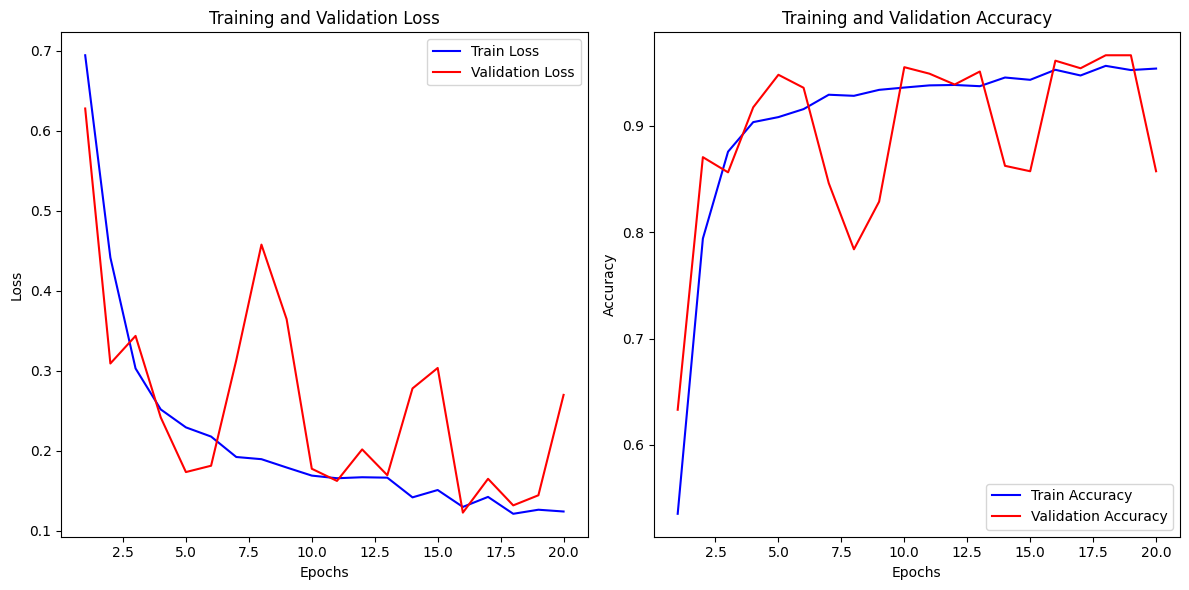

In [15]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)